#### import relevant libraries

In [0]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import pandas as pd
import random

In [0]:
%cd /content/drive/'My Drive'/

/content/drive/My Drive


In [0]:
orig_path = './Training'
normal_dir = os.path.join(orig_path, 'Normal')
damaged_dir = os.path.join(orig_path, 'Damaged')

# ids in the normal and damaged dir
normal_ids = os.listdir(normal_dir)
damaged_ids = os.listdir(damaged_dir)

#### We would be performing individual semantic segmentations 
1. AP Image <br>
    a. Vertebra <br>
    b. Spinous Process <br>
    c. Pedicle <br>
2. LAT Image <br>
    a. Verebra <br>
    b. Spinous Process <br>
    c. Disk Height <br>
    d. Anterior Vertebral Line <br>
    e. Posterior Vertebral Line <br>

In [0]:
images_AP = []
images_LAT = []
mask_AP_Vert = []
mask_AP_SP = []
mask_AP_Ped = []
mask_LAT_Vert = []
mask_LAT_DH = []
mask_LAT_SP = []
mask_LAT_AVL = []
mask_LAT_PVL = []

for id in normal_ids:
    AP_image_path = os.path.join(normal_dir, id, 'AP' , 'AP.jpg')
    AP_Vert_path = os.path.join(normal_dir, id, 'AP', 'Ap_Vertebra.png')
    AP_SP_path = os.path.join(normal_dir, id, 'AP', 'Ap_Spinous_Process.png')
    AP_Ped_path = os.path.join(normal_dir, id, 'AP', 'Ap_Pedicle.png')
    LAT_image_path = os.path.join(normal_dir, id, 'LAT', 'LAT.jpg')
    LAT_Vert_path = os.path.join(normal_dir, id, 'LAT', 'Lat_Vertebra.png')
    LAT_SP_path = os.path.join(normal_dir, id, 'LAT', 'Lat_Spinous_Process.png')
    LAT_DH_path = os.path.join(normal_dir, id, 'LAT', 'Lat_Disk_Height.png')
    LAT_AVL_path = os.path.join(normal_dir, id, 'LAT', 'Lat_Anterior_Vertebral_Line.png')
    LAT_PVL_path = os.path.join(normal_dir, id, 'LAT', 'Lat_Posterior_Vertebral_Line.png')
    
    images_AP.append(AP_image_path)
    images_LAT.append(LAT_image_path)
    mask_AP_Vert.append(AP_Vert_path)
    mask_AP_SP.append(AP_SP_path)
    mask_AP_Ped.append(AP_Ped_path)
    mask_LAT_Vert.append(LAT_Vert_path)
    mask_LAT_DH.append(LAT_DH_path)
    mask_LAT_SP.append(LAT_SP_path) 
    mask_LAT_AVL.append(LAT_AVL_path) 
    mask_LAT_PVL.append(LAT_PVL_path) 

for id in damaged_ids:
    AP_image_path = os.path.join(damaged_dir, id, 'AP' , 'AP.jpg')
    AP_Vert_path = os.path.join(damaged_dir, id, 'AP', 'Ap_Vertebra.png')
    AP_SP_path = os.path.join(damaged_dir, id, 'AP', 'Ap_Spinous_Process.png')
    AP_Ped_path = os.path.join(damaged_dir, id, 'AP', 'Ap_Pedicle.png')
    LAT_image_path = os.path.join(damaged_dir, id, 'LAT', 'LAT.jpg')
    LAT_Vert_path = os.path.join(damaged_dir, id, 'LAT', 'Lat_Vertebra.png')
    LAT_SP_path = os.path.join(damaged_dir, id, 'LAT', 'Lat_Spinous_Process.png')
    LAT_DH_path = os.path.join(damaged_dir, id, 'LAT', 'Lat_Disk_Height.png')
    LAT_AVL_path = os.path.join(damaged_dir, id, 'LAT', 'Lat_Anterior_Vertebral_Line.png')
    LAT_PVL_path = os.path.join(damaged_dir, id, 'LAT', 'Lat_Posterior_Vertebral_Line.png')
  
    images_AP.append(AP_image_path)
    images_LAT.append(LAT_image_path)
    mask_AP_Vert.append(AP_Vert_path)
    mask_AP_SP.append(AP_SP_path)
    mask_AP_Ped.append(AP_Ped_path)
    mask_LAT_Vert.append(LAT_Vert_path)
    mask_LAT_DH.append(LAT_DH_path)
    mask_LAT_SP.append(LAT_SP_path) 
    mask_LAT_AVL.append(LAT_AVL_path) 
    mask_LAT_PVL.append(LAT_PVL_path) 

# keep mask 
data = pd.DataFrame({'Images' : images_LAT, 'masks' : mask_LAT_DH})
# data_lat = pd.DataFrame({'Images' : images_LAT, 'masks' : mask_LAT_Vert})

In [0]:
# # Missing Masks
# ./Training/Damaged/ID (233)/LAT/Lat_Posterior_Vertebral_Line.png
# ./Training/Damaged/ID (169)/LAT/Lat_Spinous_Process.png

In [0]:
validation_split = .2
shuffle_dataset = True
random_seed = 42

In [0]:
# We would be splitting both data_ap and data_lat in the same way
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [0]:
# get sampler for dataloader
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [0]:
# these sizes would be later used in the train while calculating running losses and accuracy
dataset_size = {
    'train' : len(train_sampler),
    'validation' : len(valid_sampler)
} 

#### Creating a custom dataset for our segmentation and performing some augmentations to increase dataset size

In [0]:
# custom dataset for our dataset
class SpineDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = Image.open(self.data.loc[index]['Images'])
        mask = Image.open(self.data.loc[index]['masks'])

        # # Some augmentations 
        RR = RandomRotate(20)
        img, mask = RR(img, mask)
      
        if self.transform is not None:
            # Do the common ones
            img = self.transform['image'](img)
            mask = self.transform['mask'](mask)
        
        return img, mask

In [0]:
class Binarize(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, mask):
        return (mask > 0.5) * 1 

class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        return img.rotate(rotate_degree, Image.BILINEAR), mask.rotate(rotate_degree, Image.NEAREST)

In [0]:
size = [224, 224]
# size = [299, 299] # for inception_v3 net input sizes to the model should be (299, 299)

transform = {
    'image' : transforms.Compose(
    [
     transforms.Grayscale(num_output_channels=3),
     transforms.Resize(size),
     transforms.ToTensor(),
     
     ]
      ),
    'mask' : transforms.Compose(
    [
     transforms.Grayscale(num_output_channels=1),
     transforms.Resize(size),
     transforms.ToTensor(),
     Binarize()
     ]
      )
}

dataset = SpineDataset(data, transform = transform)

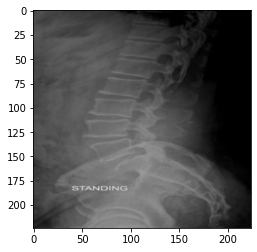

In [0]:
img = dataset.__getitem__(7)[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

In [0]:
mask = (dataset.__getitem__(7)[1].permute(1, 2, 0)).numpy()

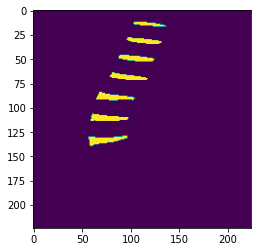

In [0]:
plt.imshow(mask.squeeze(2))

In [0]:
batch_size = 8 # Output from the dataloader should be of the form (8, 3, 224, 224) or (8, 3, 299, 299) in the case of inception_v3 net

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=0)
dataloaders = {
    'train' : train_loader,
    'validation' : validation_loader
}

In [0]:
import segmentation_models_pytorch as smp

In [0]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['spine']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [0]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])


In [0]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [0]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(validation_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_DH.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 17/17 [05:51<00:00, 20.69s/it, dice_loss - 0.2667, iou_score - 0.5826]
Model saved!

Epoch: 1
valid: 100%|██████████| 17/17 [00:18<00:00,  1.11s/it, dice_loss - 0.2368, iou_score - 0.6189]
Model saved!

Epoch: 2
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.239, iou_score - 0.6167]

Epoch: 3
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.2281, iou_score - 0.6309]
Model saved!

Epoch: 4
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.2263, iou_score - 0.6331]
Model saved!

Epoch: 5
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.219, iou_score - 0.6425]
Model saved!

Epoch: 6
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.2093, iou_score - 0.6565]
Model saved!

Epoch: 7
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.2131, iou_score - 0.651]

Epoch: 8
valid: 100%|██████████| 17/17 [00:18<00:00,  1.10s/it, dice_loss - 0.2104, 

In [0]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

ERROR! Session/line number was not unique in database. History logging moved to new session 61
